# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
# Imports 
import pandas as pd
import glob # library to get a list of files matching a pattern
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from time import strftime
import struct
import matplotlib
from os import listdir

%matplotlib inline

In [2]:
%%javascript
//remove nb_present toolbar at bottom of page
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [3]:
def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

In [4]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [5]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [6]:
# create a for loop to load all files without unzipping them?
fileList = list_files(LEGO_DATA_FOLDER, "zip")
files = list(fileList)

# extract file name only to name each dataframe 
db_names = [re.search('(?<=)(.*)(?=.csv)', file).group() for file in files] # group fct gives string of regex

# initialise a lego_db dictionary containing as keys the filenames
lego_db = dict.fromkeys(db_names) 

# give to dataframes the filenames = keys of dictionary lego_db
# key: dataframe name value: corresponding csv.file
for name, file in zip(db_names, files): 
    lego_db[name] = pd.read_csv(LEGO_DATA_FOLDER+'/'+file, compression="zip")

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

__\* Briefly explain your approach here \*__



First we look at the values to visualize if there are any aberrant or inconsistent values present in *inventory_parts* and *sets*. We compute the max, min, average and unique values. We observe that for *year* field in *sets* negative values and ill-formatted years are present. For *inventory_parts* field *quantity* the average is -inf.

In [7]:
range_sets_year = (lego_db["sets"]["year"].min(), lego_db["sets"]["year"].max())
print("Time range of sets[year] (min, max): {}".format(range_sets_year))

average_inventory_parts_quantity = lego_db["inventory_parts"]["quantity"].mean()
print("Average of inventory parts[quantity]: {}".format(average_inventory_parts_quantity))

unique_sets_year = set(lego_db["sets"]["year"].tolist())
unique_inventory_parts_quantity = set(lego_db["inventory_parts"]["quantity"].tolist())

print("\n Unique values of sets[year] \n")
print(unique_sets_year)
print("\n Unique values of inventory_parts[quantity] \n")
print(unique_inventory_parts_quantity)


Time range of sets[year] (min, max): ('-1962', '80s')
Average of inventory parts[quantity]: -inf

 Unique values of sets[year] 

{'-1979', '1977', '-20122', '2004', '2012', '1998', '-1987', '-20144', '1988', '-1982', '19722', '19877', '-20100', '1986', '1985', '-2006', '-1997', '-1993', '-1994', '1999', '20111', '1955', '70s', '-20166', '1987', '20066', '1996', '-2010', '-1975', '2015', '1956', '20177', '19955', '19988', '1982', '2002', '1994', '-2001', '-2013', '2003', '2005', '-2002', '1973', '19699', '19855', '1971', '-1988', '1983', '-20111', '20044', '1974', '-1966', '1959', '19833', '-1998', '19899', '19911', '2000', '19866', '-1980', '20077', '19822', '19777', '20122', '-1977', '-20155', '20011', '19788', '20155', '-1999', '-20099', '-20033', '19977', '1964', '20000', '1958', '-2007', '1967', '-19977', '1995', '1984', '2014', '-2009', '2016', '2006', '1957', '1960', '20022', '-1984', '1968', '-2004', '1979', '2010', '20133', '2017', '-2017', '19555', '-2016', '-2011', '-2014', '

**Problematic values.**
Before removing inconsistences, we define and quantify problematic values: 
1. *year* = (neg, char not number (eg. 80s), \> 4 numbers): we extract accepted values as those having exactly 4 digits
2. *quantity* = -inf : we extract accepted values as those having only digits

We extract problematic values by negating accepted values. 


In [8]:
# define aberrant values : year aberrant values: {neg, char, > 4 numbers}
# 1. match year all years that do not have exactly 4 digits 
accepted_values_year = set([re.match("\d{4}",ele).group() for ele in lego_db['sets'].year 
                                if re.match("\d{4}",ele) ]) 
# 2. match quantity that are digits
accepted_values_quantities = set([re.match("\d+", str(ele)).group() for ele in lego_db['inventory_parts'].quantity
                                 if re.match("\d+", str(ele))])

In [9]:
# extract problematic values only by negating accepted values
problematic_years = lego_db['sets'][~lego_db["sets"].year.isin(accepted_values_year)].year

# quantities: select problematic values and group by quantities
problematic_quantities_idx = ~lego_db["inventory_parts"].quantity.isin(accepted_values_quantities)
problematic_quantities = lego_db['inventory_parts']["quantity"][problematic_quantities_idx]

**Aberrant values**. We want to remove all aberrant values containing strings: 
1. Years (eg. 70s, 80s)
2. Quantities (eg. -inf)

We first visualize a histogram of the frequency of such values to see if removing these data would lead to too much data loss.

In [10]:
aberrant_years_idx = [True if re.search("[a-z]",ele) else False for ele in problematic_years]

print("Aberrant quantity values to be removed: {}".format(
    set(lego_db['inventory_parts'][problematic_quantities_idx].quantity)))

Aberrant quantity values to be removed: {-inf}


In [11]:
aberrant_years = problematic_years.iloc[aberrant_years_idx]

In [12]:
# group by only values that have string 70s, 80s.
aberrant_years_groupby = aberrant_years.groupby(aberrant_years.values).size()

In [13]:
# quantities: group by values having -inf to see if few values or many have such quantity value
aberrant_quantities_groupby = problematic_quantities.groupby(problematic_quantities).size()

In [14]:
aberrant_quantities_groupby

quantity
-inf    161796
Name: quantity, dtype: int64

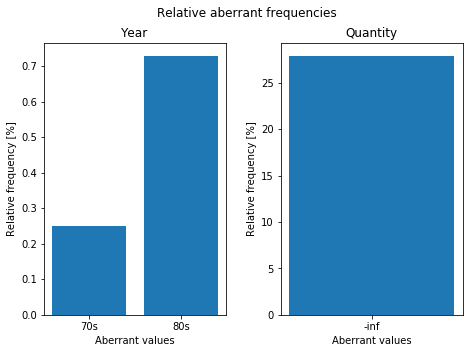

In [15]:
# histogram of frequency of aberrant values 
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(7.5, 5)) # subplots

fig.subplots_adjust(wspace = 0.3)

axes[0].bar(aberrant_years_groupby.index, 
            aberrant_years_groupby.values*100/len(lego_db['sets'].index))
axes[0].set(title = "Year", ylabel="Relative frequency [%]", xlabel="Aberrant values")

axes[1].bar("-inf", 
            aberrant_quantities_groupby.values*100/len(lego_db['inventory_parts'].index))

axes[1].set(title = "Quantity", ylabel="Relative frequency [%]", xlabel="Aberrant values")

fig.suptitle("Relative aberrant frequencies")

plt.show()

After aberrant values quantification, we now process the problematic values. 

For the year:
1. Remove years containing strings because we don't know the year (eg. 80s)
2. Remove the - sign because systematic error due to non-uniform data entry formatting
3. Select only the 4 first digits out of 5. It seems again a systematic error: we assume last digit was a typo (eg. 19622 -> 1962)
4. Find years < 1931 (1932 founding date of LEGO) and years > 2019 after having quantified data loss and change them to 0

For quantity: we cannot remove all -inf entries as they represent >25% of the quantity field. We remplace them by 0 and convert to int because a quantity is an integer. 

In [16]:
# 1.
lego_db['sets'].drop(aberrant_years.index, inplace=True)


print("We have removed all entries containing string years {}".format(
    lego_db['sets'][lego_db['sets'].year.isin(["80s","70s"])])
     )

We have removed all entries containing string years Empty DataFrame
Columns: [id, name, year, theme_id, num_parts]
Index: []


In [17]:
# 2. remove - character (considered as typo)
lego_db['sets'].year = lego_db['sets'].year.astype(np.uint16)

In [18]:
# 3. replace 5 digits to 4 first digits
lego_db['sets'].year = lego_db['sets'].year.map(
    lambda ele: np.uint16(re.match("\d{4}", str(ele)).group())
)

In [19]:
# 4. condition: valid years < 1931 or > 2019 
# all years that are not "valid" years need to be replaced to 0

lego_db['sets'].year.where(
    ((lego_db['sets'].year > 1931) & (lego_db['sets'].year < 2019)), other=0, inplace=True
)

For quantity: we replace -inf by 0. We notice that there is no 0 quantity in the data so we assume that -inf means 0.

In [20]:
# replace all quantities that are -inf to -1
lego_db['inventory_parts'].quantity = lego_db['inventory_parts'].quantity.where(
    lego_db['inventory_parts'].quantity != float('-inf'), other=0, inplace=False
).astype(dtype=np.int16)

### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

#### Query 1

In [21]:
# Query 1 
set(lego_db['sets'].name)

cars = lego_db['sets'][lego_db['sets'].name.str.contains('(\w{3,}car($|[[:space:]])|Car($|[[:space:]]|s))')]

cars.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


,id,name,year,theme_id,num_parts
27,10002-1,Railroad Club Car,2001,233,272
50,10022-1,"Santa Fe Cars - Set II (dining, observation, o...",2002,237,410
53,10025-1,Santa Fe Cars - Set I (mail or baggage car),2002,237,325
142,10158-1,High Speed Train Car,2004,239,151
154,10170-1,TTX Intermodal Double-Stack Car,2005,236,365


In [22]:
invetoryIDsWithCars = lego_db['inventory_sets'][lego_db['inventory_sets']['set_id'].isin(cars['id'])]['inventory_id'];
invetoryIDsWithCars.head()

111     528
167     908
253    1371
254    1371
263    1401
Name: inventory_id, dtype: int64

#### Query 2
To distribution of part categories as a (horizontal) bar chart, we:
1. We count the number of *id* from *parts* grouped by *part_cat_id* to find the number of parts belonging to each category. We order the groups by their number of *id* and select the top 20. So we have selected the 20 largest part categories in terms of number of parts belonging to the category.
2. We select the *name* corresponding to the *part_cat_id* by joining the table to *part categories* on *part_cat_id*. Results obtained are sorted in descending fashion according to number of parts 
3.  plot distribution of part categories with a horizontal bar plot

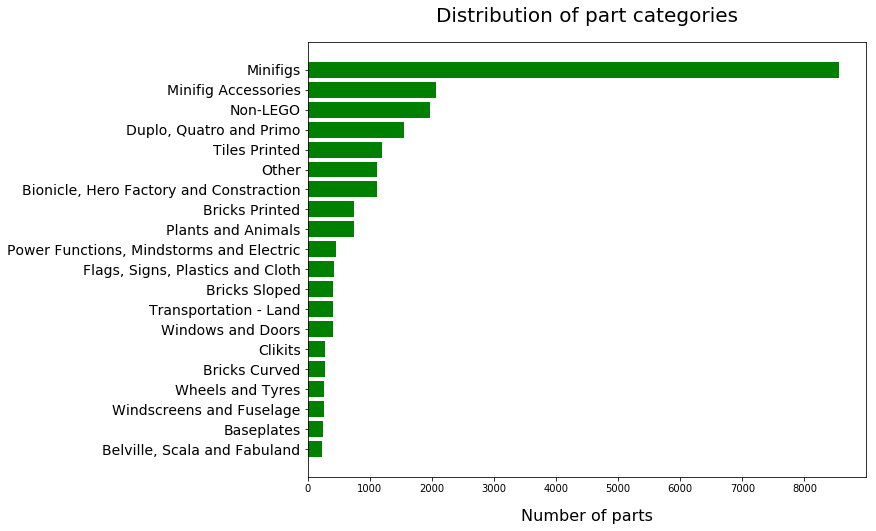

In [23]:
# Query 2
# 1. Select count(id) from parts group by part_cat_id order by count(id) desc fetch first 20 

grouped_part_cat_id_best20 = lego_db['parts'].groupby(
    'part_cat_id').size().to_frame('count').sort_values('count', ascending = False).iloc[:20]

# 2. Select part_categories.name, parts.count
# from part_categories inner join parts on parts.part_cat_id = part_categories.id

part_categories_best20 = lego_db['part_categories'].merge(
    grouped_part_cat_id_best20, 
    left_on= 'id', 
    right_on= 'part_cat_id', 
    how= 'inner'
)[['name','count']].sort_values('count', ascending = False)

# plot distribution of part categories (horizontal bar plot)
fig, ax = plt.subplots(figsize=(10,8))

y_pos = part_categories_best20['name'].values
x_pos = part_categories_best20['count'].values
ax.barh(
    y_pos, 
    x_pos, 
    align='center',
    color='green'
)

ax.set_yticks(y_pos)
ax.set_yticklabels(y_pos, {'fontsize': 14})

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(
    'Number of parts', 
    {'fontsize': 16}, 
    labelpad=15
)
ax.set_title(
    'Distribution of part categories',
    {'fontsize': 20},
    pad=20
)

plt.show()

#### Query 3 

We assume that the attribute *quantity* of the *inventory_set* table is the number of set present in the inventory. Therefore, we won't use it to compute the dominant color for each set, because the quantity is to respect of the set present in the inventory.

1. To find the dominant colour for each *set*, we first join *inventory sets* with *inventory parts* on *inventory id* to find the parts that compose each set.
2. We group by *set id*, *colour id* and sum quantity according to the *colour id* and *set id*. 
3. Extract dominant *colour id* per set according to maximal summed quantity 
4. Merge resulting table with *colours* to retrieve dominant colour *name* for each set according respective dominant *colour id*

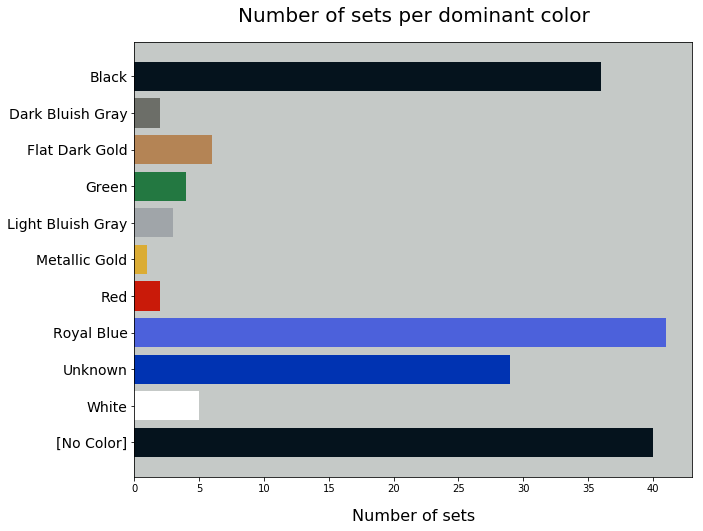

In [24]:
# Query 3
# 1. merge inv_sets with inv_parts 
sets_parts_join = lego_db['inventory_sets'].merge(
    lego_db['inventory_parts'], 
    on='inventory_id',
    how='inner'
)[['set_id', 'color_id', 'quantity_y']]

# 2. group by set_id and color_id and sum quantities to the color_id and set_id
sets_parts_grouped = sets_parts_join.groupby(['set_id', 'color_id']).aggregate(np.sum)

# 3. extract the dominant color_id per set
set_dominant_color_id = sets_parts_grouped.groupby('set_id').aggregate(
    lambda x: x.idxmax()[1]
).rename({'quantity_y': 'set_dominant_color_id'}, axis=1)

# 4. Merge with color table to retrieve color names from color_id
set_dominant_color = set_dominant_color_id.reset_index().merge(
    lego_db['colors'],
    right_on='id',
    left_on='set_dominant_color_id',
    how='inner'
)[['set_id', 'name', 'rgb']]

# 5. plot using a (horizontal) bar chart, the number of sets per dominant color. 
# Color each bar with the respective color that it represents.
set_dominant_color_grouped = set_dominant_color.groupby(['name','rgb']).size().to_frame('Number_sets').reset_index()

# transform hex code in rgb field to rgb code and later in plot use convert to_rgb.
rgb_conversion = lambda rgbstr: tuple([ele/255 for ele in list(struct.unpack('BBB', bytes.fromhex(rgbstr)))])
set_dominant_color_grouped.rgb = set_dominant_color_grouped.rgb.map(rgb_conversion)

fig, ax = plt.subplots(figsize=(10,8))

ax.barh(
    set_dominant_color_grouped['name'].values, 
    set_dominant_color_grouped['Number_sets'].values.ravel(),
    color = [matplotlib.colors.to_rgb(x) for x in set_dominant_color_grouped.rgb]
)

ax.set_yticks(set_dominant_color_grouped['name'].values)
ax.set_yticklabels(set_dominant_color_grouped['name'].values, {'fontsize': 14})

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(
    'Number of sets', 
    {'fontsize': 16}, 
    labelpad=15
)
ax.set_title(
    'Number of sets per dominant color',
    {'fontsize': 20},
    pad=20
)

ax.set_facecolor('xkcd:silver')

plt.show()

#### Query 4
First convert dominant colors of the output of query 3 into rgb: the dominant colors for each sets are converted into rgb. Same procedure was carried out in plotting of query 3 but with another table.

In [25]:
rgb_conversion = lambda rgbstr: struct.unpack('BBB', bytes.fromhex(rgbstr))
set_dominant_color.rgb = set_dominant_color.rgb.apply(rgb_conversion)
set_dominant_color.tail()

,set_id,name,rgb
164,8582-1,Flat Dark Gold,"(180, 132, 85)"
165,8583-1,Flat Dark Gold,"(180, 132, 85)"
166,8584-1,Flat Dark Gold,"(180, 132, 85)"
167,8585-1,Flat Dark Gold,"(180, 132, 85)"
168,8586-1,Flat Dark Gold,"(180, 132, 85)"


Then, compute the  luminance of the dominant colors for each sets.

In [26]:
luminescence = lambda x: np.sqrt(0.299*x[0]**2+0.587*x[1]**2+0.114*x[2]**2)
set_dominant_color['luminescence'] = set_dominant_color.rgb.apply(luminescence)
set_dominant_color.tail()

,set_id,name,rgb,luminescence
164,8582-1,Flat Dark Gold,"(180, 132, 85)",144.010895
165,8583-1,Flat Dark Gold,"(180, 132, 85)",144.010895
166,8584-1,Flat Dark Gold,"(180, 132, 85)",144.010895
167,8585-1,Flat Dark Gold,"(180, 132, 85)",144.010895
168,8586-1,Flat Dark Gold,"(180, 132, 85)",144.010895


Join the *sets* table to retrieve the year at which sets were pubblished.

In [27]:
set_dominant_color_year = set_dominant_color.merge(
    lego_db['sets'][lego_db['sets'].year != 0],
    left_on='set_id',
    right_on='id',
    how='inner'
)[['luminescence', 'year']]

set_dominant_color_year.tail()

,luminescence,year
143,144.010895,2003
144,144.010895,2003
145,144.010895,2003
146,144.010895,2003
147,144.010895,2003


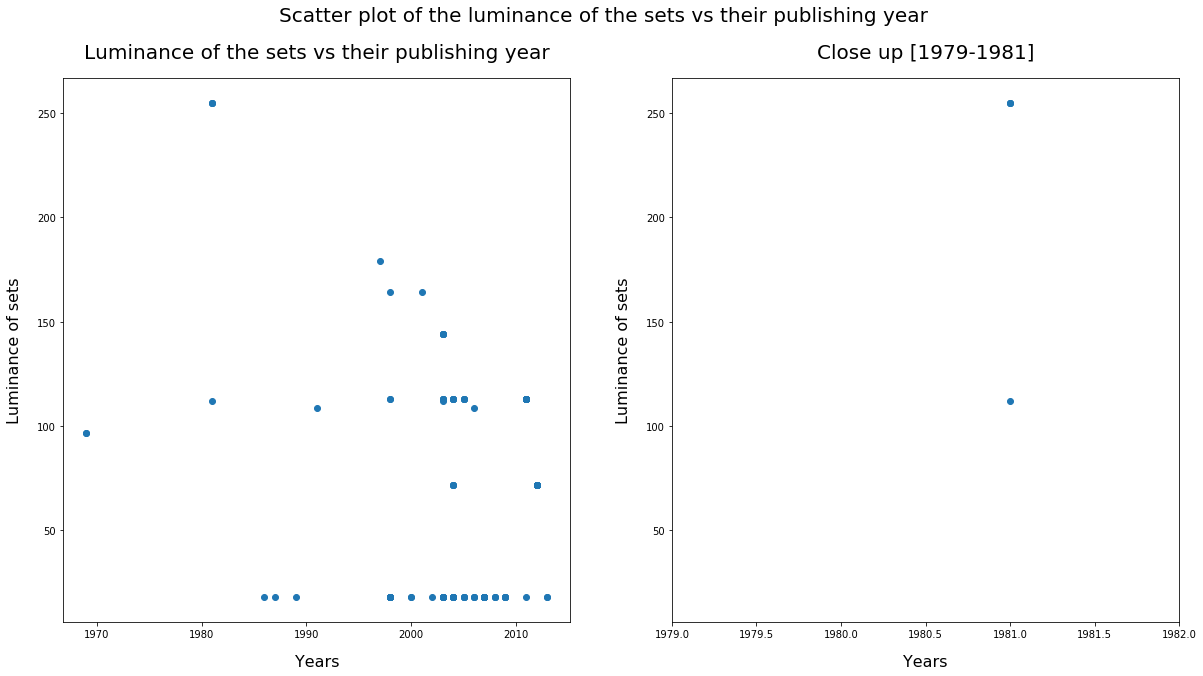

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].scatter(set_dominant_color_year.year, set_dominant_color_year.luminescence)
ax[1].scatter(set_dominant_color_year.year, set_dominant_color_year.luminescence)
ax[1].set_xlim(left=1979, right=1982)

ax[0].set_xlabel(
    'Years', 
    {'fontsize': 16}, 
    labelpad=15
)
ax[1].set_xlabel(
    'Years', 
    {'fontsize': 16}, 
    labelpad=15
)


ax[0].set_ylabel(
    'Luminance of sets', 
    {'fontsize': 16}, 
    labelpad=15
)
ax[1].set_ylabel(
    'Luminance of sets', 
    {'fontsize': 16}, 
    labelpad=15
)

ax[0].set_title(
    'Luminance of the sets vs their publishing year',
    {'fontsize': 20},
    pad=20
)

ax[1].set_title(
    'Close up [1979-1981]',
    {'fontsize': 20},
    pad=20
)

fig.suptitle("Scatter plot of the luminance of the sets vs their publishing year", fontsize=20)

plt.show()

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [29]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

*Trip ID* is set as the key of the dataframe because it is unique and a good candidate key to represent the dataframe

In [30]:
bikes = pd.read_json(
    BIKES_DATA_FOLDER+'/metro-bike-share-trip-data.json.zip',
    compression='zip'
)

# set idx as trip id (trip id is the key of the relation because it is unique)
key_rel = 'Trip ID'
bikes = bikes.rename({old:new for old, new in zip(bikes.index.values, bikes[key_rel])})
bikes.set_index(key_rel, inplace=True)

bikes.tail(3)

,Bike ID,Duration,End Time,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Passholder Type,Plan Duration,Start Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Trip Route Category
Trip ID,,,,,,,,,,,,,
23660991,6183.0,480,2017-03-31T23:52:00,3054.0,34.039219,-118.236488,Walk-up,0.0,2017-03-31T23:44:00,3082.0,34.046520,-118.237411,One Way
23660990,5900.0,420,2017-03-31T23:52:00,3054.0,34.039219,-118.236488,Walk-up,0.0,2017-03-31T23:45:00,3082.0,34.046520,-118.237411,One Way
23664826,6207.0,1260,2017-04-01T00:06:00,3029.0,34.048851,-118.246422,Walk-up,0.0,2017-03-31T23:45:00,3078.0,34.064281,-118.238937,One Way


### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

__\* Briefly explain your approach here \*__

Types and ranges are shown below. Ranges are only compute on numerical attributes for now.

In [31]:
#  dtype returns a Series with the data type of each column/attribute in bikes
bikes.dtypes

Bike ID                       float64
Duration                        int64
End Time                       object
Ending Station ID             float64
Ending Station Latitude       float64
Ending Station Longitude      float64
Passholder Type                object
Plan Duration                 float64
Start Time                     object
Starting Station ID           float64
Starting Station Latitude     float64
Starting Station Longitude    float64
Trip Route Category            object
dtype: object

In [32]:
ranges = pd.concat(
    [
        bikes.describe().loc['max'] - bikes.describe().loc['min'],
        bikes.describe().loc['max'],
        bikes.describe().loc['min']
    ], 
    axis=1
).T

ranges

,Bike ID,Duration,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Plan Duration,Starting Station ID,Starting Station Latitude,Starting Station Longitude
0,5379.0,86340.0,1108.0,34.064281,118.472832,365.0,1108.0,34.064281,118.472832
max,6728.0,86400.0,4108.0,34.064281,0.000000,365.0,4108.0,34.064281,0.000000
min,1349.0,60.0,3000.0,0.000000,-118.472832,0.0,3000.0,0.000000,-118.472832


Categorical attributes are indicated and transformed.

In [33]:
# select all attributes that we couldn't compute statistics
transform_attributes = [attribute for attribute in bikes.columns.values.tolist() 
                        if attribute not in ranges.columns.values]
print(transform_attributes)

# transform these attributes to categorical
bikes[transform_attributes] = bikes[transform_attributes].astype("category")

['End Time', 'Passholder Type', 'Start Time', 'Trip Route Category']


Redundant columns (i.e. columns whose value depends only on the value of another column) 
- Duration, Start Time, End Time
- Starting Station ID, Starting Station Latitude, Starting Station Longitude (eg. Station ID identified by GPS coordinates)
- Ending Station ID, Ending Station Latitude, Ending Station Longitude

In [34]:
redundant_columns = [
    'Start Time', 'End Time', 'Starting Station Latitude', 
    'Starting Station Longitude','Ending Station Latitude', 
    'Ending Station Longitude'
]

start_time = pd.DataFrame(data = bikes['Start Time'], index=bikes.index)
end_time = pd.DataFrame(data = bikes['End Time'], index=bikes.index)
starting_station = pd.DataFrame(
    data = bikes[[
        'Starting Station ID',
        'Starting Station Latitude', 
        'Starting Station Longitude'
    ]], index=bikes.index
)

ending_station = pd.DataFrame(
    data = bikes[[
        'Ending Station ID', 
        'Ending Station Latitude',
        'Ending Station Longitude'
    ]], index=bikes.index
)
# drop redundant columns 
bikes.drop(redundant_columns, axis=1, inplace=True)
bikes.head(3)

,Bike ID,Duration,Ending Station ID,Passholder Type,Plan Duration,Starting Station ID,Trip Route Category
Trip ID,,,,,,,
1912818,6281.0,180,3014.0,Monthly Pass,30.0,3014.0,Round Trip
1919661,6281.0,1980,3014.0,Monthly Pass,30.0,3014.0,Round Trip
1933383,5861.0,300,3016.0,Flex Pass,365.0,3016.0,Round Trip


Pitfalls of having redundant columns in a single dataframe:
1. Having many columns in a single dataframe is extra IO and storage cost. Therefore, storing redundant columns as separate dataframes ensures that we only access this subset of columns if needed. 
2. Having redundant information can lead to inconsistencies in the data: you can miss-type the duration or the starting time. 
3. By putting these columns in different dataframes, if we were working with a real database, the level of information a user has access to can be controlled. For instance, we could set permissions on different dataframes. *Starting ID* is retained in *bikes*, however the exact GPS coordinates may be stored in a different file, which would restrict user acess to this level of information. 

The format **with redundancy** is more susceptible to inconsistencies because redundant information increase the occurrence of mistakes and the redundant informations are not linked together: Start Time, End Time, Duration all mean the same but the user cannot see a direct link as in SQL with constraints, primary keys...

In [35]:
# for each dataframe type of each column and it's shape is printed
dataframes_to_print = [start_time, end_time, starting_station, ending_station]

print("Dataframe type and shape")
for dataframe_x in dataframes_to_print:
    print(dataframe_x.dtypes, dataframe_x.shape)

Dataframe type and shape
Start Time    category
dtype: object (132427, 1)
End Time    category
dtype: object (132427, 1)
Starting Station ID           float64
Starting Station Latitude     float64
Starting Station Longitude    float64
dtype: object (132427, 3)
Ending Station ID           float64
Ending Station Latitude     float64
Ending Station Longitude    float64
dtype: object (132427, 3)


In [36]:
# reformat dates by creating new columns
format_raw = "%Y-%m-%dT%H:%M:%S"

format_hour = lambda x: datetime.strptime(x, format_raw).strftime('%H:%M:%S')
format_day = lambda x: datetime.strptime(x, format_raw).strftime('%Y-%m-%d') 

for df, col in zip([start_time, end_time], [start_time.columns[0], end_time.columns[0]]):
    df['hours'] = df[col].apply(format_hour)
    df['day'] = df[col].apply(format_day)
    df.drop(axis=1, columns=[col], inplace=True)

    
# restricted to 24h, remove outlier
bikes = bikes[bikes['Duration']<5000]

start_time.head(3)

,hours,day
Trip ID,,
1912818,04:17:00,2016-07-07
1919661,06:00:00,2016-07-07
1933383,10:32:00,2016-07-07


### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

#### Query 1.
 Find the number of outgoing trips from each station by grouping by *Starting Station ID*. 
 Plot the distribution of the number of outgoing trips from each station in a histogram with 20 bins

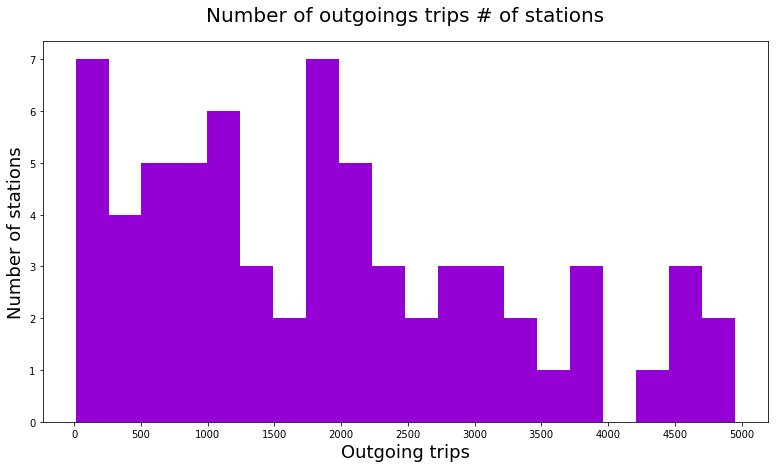

In [37]:
outgoingCounts = bikes.groupby('Starting Station ID').agg({'Bike ID':'count'})

#renaming:
outgoingCounts.columns = ['Outgoing']

n_bins = 20

fig, ax = plt.subplots(figsize=(13,7))
plt.hist(outgoingCounts['Outgoing'], n_bins, facecolor='#9400D3')
plt.title('Number of outgoings trips # of stations', fontsize=20, pad=20)
plt.xlabel('Outgoing trips', fontsize=18)
plt.ylabel('Number of stations',fontsize=18)
ax.set_xticks(ticks=np.arange(0,5500,500))

plt.show()

#### Query 2
Compute the frequency of the hours of the trip starting hour in a day to see popular times.
We used *hour* field in *start time*. We then plotted the histograms using 1-hour intervals to represent a full 24h day.

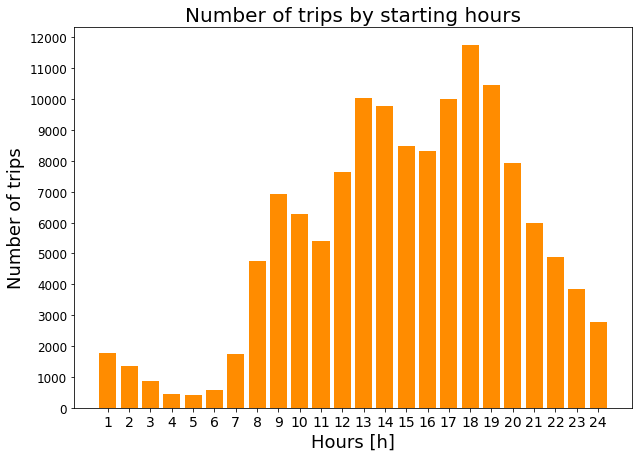

In [38]:
startingHours = pd.DataFrame(start_time['hours'].str[:2])
groupedStartingHours = startingHours.groupby('hours').agg({'hours':'count'}) # grouping because of performances

#renaming:
groupedStartingHours.columns = ['countedByHours']

ind = np.arange(len(groupedStartingHours)) # the x locations for the groups

fig, ax = plt.subplots(figsize=(10,7))

rects1 = ax.bar(ind, groupedStartingHours['countedByHours'], color='#FF8C00')

ax.set_ylabel('Number of trips', fontsize=18)
ax.set_xlabel('Hours [h]', fontsize=18)
ax.set_title('Number of trips by starting hours', fontsize=20)
ax.set_xticks(ind)
ax.set_xticklabels(ind+1, {'fontsize': '14'})
ax.set_yticks(np.arange(0, 13000, 1000))
ax.set_yticklabels(np.arange(0, 13000, 1000), {'fontsize': '12'})
plt.show()
# ax.set_xticklabels(ind+1, {'fontsize': '14'});

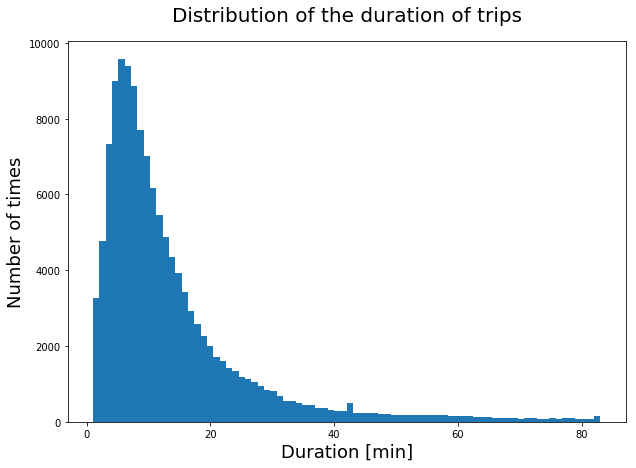

In [39]:
n_bins = 80
fig = plt.subplots(figsize=(10,7))
plt.hist(bikes['Duration']/60, n_bins)
plt.ylabel('Number of times',fontsize=18)
plt.xlabel('Duration [min]', fontsize=18)
plt.title('Distribution of the duration of trips', fontsize=20, pad=20)

plt.show()

**Duration plot**
We plotted the frequency of durations. Intuitively, short durations should be the most frequent. We expect a fast decrease. After roughly 15 min trip duration, a decrease is seen. All popular values are those less than 15 min.

**Trip starting hour plot**
Duarnal patterns are observed. Human behaviour and circadian clock (start working, lunch, leave work) can be inferred from such a plot with 3 local maxima (9am, 1pm, 6pm). Around 9am, a first peak emerges depicting people running to work. Around lunchtime (1pm), trips start up again. Finally, around 6pm, bike trips shoot up due to the end of the working day. Also, around 4-5am, bikes trips die down as everyone is sleeping.

#### Query 3.
We select *trip route category*, *passholder type*, *count_trips* 
from *bikes* 
and group by *trip route category*, *passholder type*.
Then, for each *trip route category*, we sum all the *passholder types* to get the sum of each *trip route category* and finally divide the number of *trip route category* for each *passholder type* by the sum of their respective *trip route category* to get the normalized height.

In [40]:
# Query 3 : select trip route category, passholder type, count_trips from bikes and
# group by trip route category, passholder type 
trip_cat_passholder = bikes.groupby(['Trip Route Category', 'Passholder Type']).size().to_frame('count_trips')

# sum all passholder type counts by trip route category 
sum_per_trip_cat = trip_cat_passholder.groupby(level=0).aggregate(np.sum)
trip_cat_passholder.merge(right=sum_per_trip_cat, on='Trip Route Category', how='left')

# normalize height by dividing for each trip route category and passholder type by sum of their trip route category
proportion_trip_pass_normalized = trip_cat_passholder*100/sum_per_trip_cat

# to check that the sum of each trip route category sums up 100%
checking_trip = (trip_cat_passholder/sum_per_trip_cat).groupby(level=0).aggregate(np.sum)

proportion_trip_pass_normalized

count_trips
Trip Route Category Passholder Type             
One Way             Flex Pass           7.605252
                    Monthly Pass       65.854936
                    Staff Annual        0.225831
                    Walk-up            26.313982
Round Trip          Flex Pass           3.978543
                    Monthly Pass       32.346893
                    Staff Annual        0.733125
                    Walk-up            62.941439

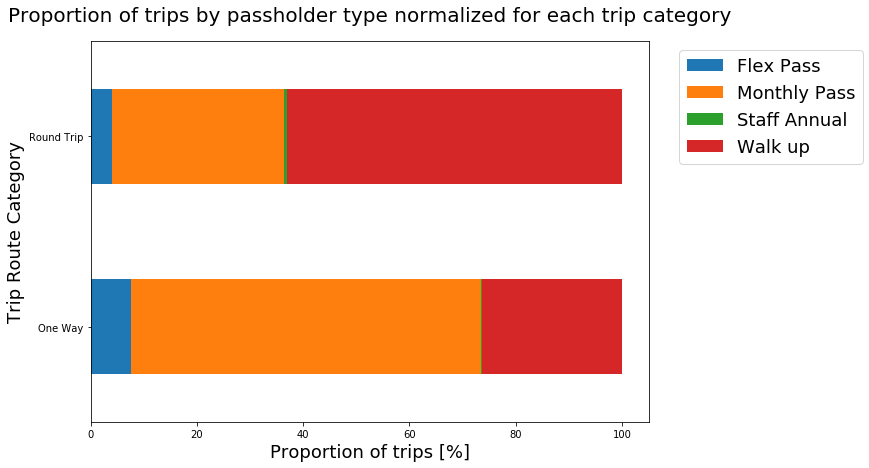

In [41]:
# Plot Proportion of trips by passholder type normalized for each trip category using barh stacked
ax = proportion_trip_pass_normalized.unstack(level=1).plot(
    kind='barh',subplots=False, stacked=True, figsize=(10,7)
)

ax.set_title(
    'Proportion of trips by passholder type normalized for each trip category',
    {'fontsize': 20},
    pad = 20
)

ax.legend(['Flex Pass', 'Monthly Pass', 'Staff Annual', 'Walk up'], prop={'size': 18}, bbox_to_anchor=(1.4, 1))
ax.set_xlabel('Proportion of trips [%]', {"fontsize": 18})
ax.set_ylabel('Trip Route Category', {"fontsize": 18})

plt.show()

In [42]:
# Query 4
# select only trips that begin in the morning hours
trips_morning = bikes.loc[start_time.hours < '12:00:01']
# group by both Passholder Type, Trip Route Category
group_trips_moring = trips_morning.groupby(['Passholder Type', 'Trip Route Category']).size().to_frame('Proportion')
# Compute percentage per Passholder Type
percentages_passholder = group_trips_moring/group_trips_moring.groupby(level=0).aggregate(np.sum)*100
percentages_passholder

Proportion
Passholder Type Trip Route Category            
Flex Pass       One Way               95.971914
                Round Trip             4.028086
Monthly Pass    One Way               96.050134
                Round Trip             3.949866
Staff Annual    One Way               67.500000
                Round Trip            32.500000
Walk-up         One Way               80.635737
                Round Trip            19.364263

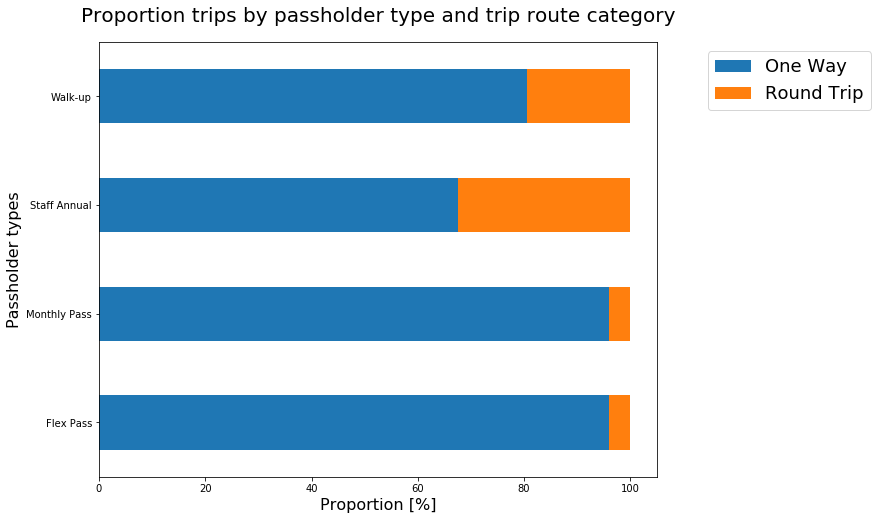

In [43]:
ax = percentages_passholder.unstack(level=1).plot(
    kind='barh', 
    subplots=False, 
    figsize=(10, 8),
    stacked=True
)

ax.set_title(
    'Proportion trips by passholder type and trip route category',
    {'fontsize': 20},
    pad=20
)
ax.set_xlabel('Proportion [%]', {'fontsize': 16})
ax.set_ylabel('Passholder types', {'fontsize': 16})
ax.legend(['One Way', 'Round Trip'], prop={'size': 18}, bbox_to_anchor=(1.4, 1))

plt.show()

#### Query 5

Select 15h as approx. estimated mediane hour at which the stations show roughly the same number of bike leaving the stations. We merge bikes with the times at which the bikes leave the station. Separate this merged dataframe according to the threshold (15h) chosen before. Finally, groupy by the interval, the passholder and the trip route category.

Monthly Pass proportion does not seem to be affected by the time interval --> no benefit for the company

In [44]:
#creating DataFrame:
hourTreshold = 15; #estimated and approximative mediane

bikesCompletes = pd.concat([bikes,start_time],axis = 1, join='inner')

bikesCompletes['hours'] = pd.to_numeric(bikesCompletes['hours'].str[:2])

bikesCompletes['timeSlot'] = 1
bikesCompletes.loc[bikesCompletes['hours'] < hourTreshold, 'timeSlot'] = 0

bikesCounts = bikesCompletes.groupby(['timeSlot','Passholder Type','Trip Route Category']).agg({'Bike ID':'count'})

bikesCounts = bikesCounts.reset_index()
bikesCounts

,timeSlot,Passholder Type,Trip Route Category,Bike ID
0,0,Flex Pass,One Way,4514
1,0,Flex Pass,Round Trip,241
2,0,Monthly Pass,One Way,38867
3,0,Monthly Pass,Round Trip,1965
4,0,Staff Annual,One Way,158
5,0,Staff Annual,Round Trip,56
6,0,Walk-up,One Way,14491
7,0,Walk-up,Round Trip,3288
8,1,Flex Pass,One Way,4343
9,1,Flex Pass,Round Trip,204


In [45]:
# Monthly Pass proportion does not seem to be affected by the time interval 
# --> no benefit for the company
bikesCounts[bikesCounts['Passholder Type'] == 'Monthly Pass']['Bike ID'].to_frame()

,Bike ID
2,38867
3,1965
10,37827
11,1649
